consensus score: 1.0


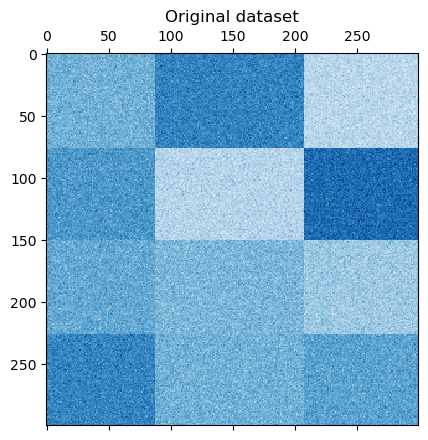

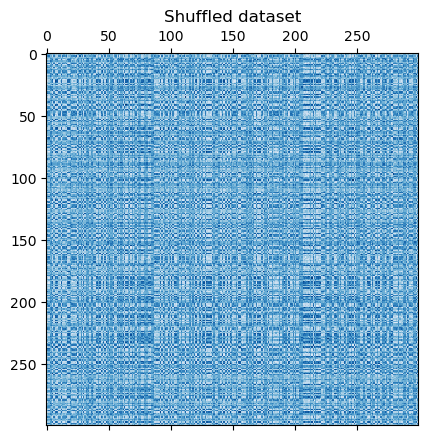

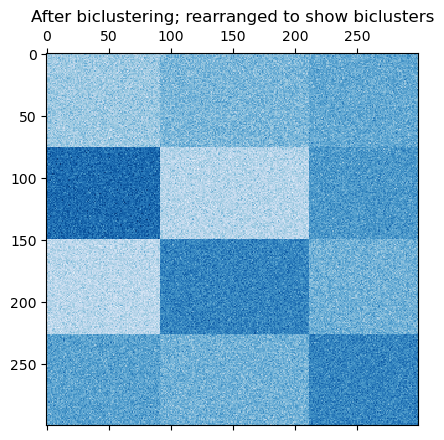

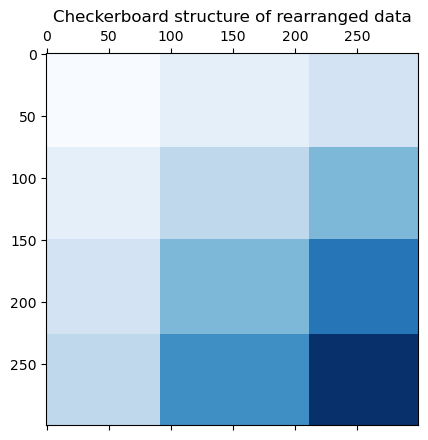

In [8]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score


n_clusters = (4, 3)
data, rows, columns = make_checkerboard(
    shape=(300, 300), n_clusters=n_clusters, noise=10, shuffle=False, random_state=0
)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")

# shuffle clusters
rng = np.random.RandomState(0)
row_idx = rng.permutation(data.shape[0])
col_idx = rng.permutation(data.shape[1])
data = data[row_idx][:, col_idx]

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")

model = SpectralBiclustering(n_clusters=n_clusters, method="log", random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_, (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.1f}".format(score))

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.matshow(
    np.outer(np.sort(model.row_labels_) + 1, np.sort(model.column_labels_) + 1),
    cmap=plt.cm.Blues,
)
plt.title("Checkerboard structure of rearranged data")

plt.show()

Accuracy (train) for L1 logistic: 82.7% 
Accuracy (train) for L2 logistic (Multinomial): 82.7% 
Accuracy (train) for L2 logistic (OvR): 79.3% 
Accuracy (train) for Linear SVC: 82.0% 
Accuracy (train) for GPC: 82.7% 


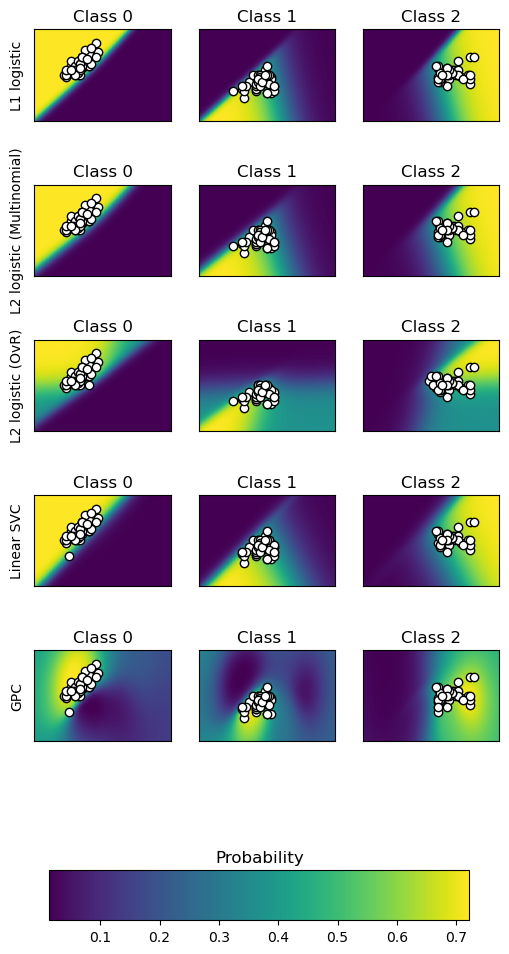

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, 0:2]  # we only take the first two features for visualization
y = iris.target

n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(
        C=C, penalty="l1", solver="saga", multi_class="multinomial", max_iter=10000
    ),
    "L2 logistic (Multinomial)": LogisticRegression(
        C=C, penalty="l2", solver="saga", multi_class="multinomial", max_iter=10000
    ),
    "L2 logistic (OvR)": LogisticRegression(
        C=C, penalty="l2", solver="saga", multi_class="ovr", max_iter=10000
    ),
    "Linear SVC": SVC(kernel="linear", C=C, probability=True, random_state=0),
    "GPC": GaussianProcessClassifier(kernel),
}

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=0.2, top=0.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(
            probas[:, k].reshape((100, 100)), extent=(3, 9, 1, 5), origin="lower"
        )
        plt.xticks(())
        plt.yticks(())
        idx = y_pred == k
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker="o", c="w", edgecolor="k")

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation="horizontal")

plt.show()

In [19]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [20]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.076s	69662	0.680	0.719	0.699	0.570	0.695	0.169
random   	0.052s	69707	0.675	0.716	0.694	0.560	0.691	0.177
PCA-based	0.021s	72713	0.637	0.659	0.648	0.521	0.644	0.143
__________________________________________________________________________________


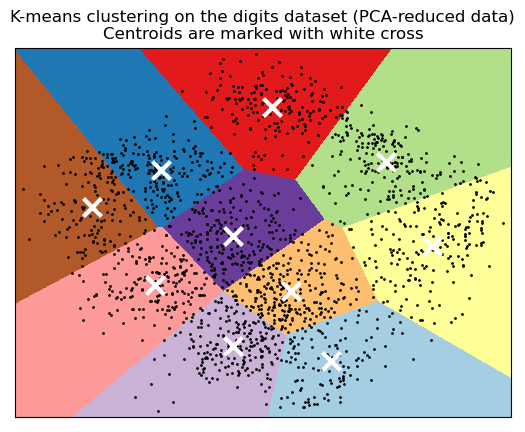

In [23]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

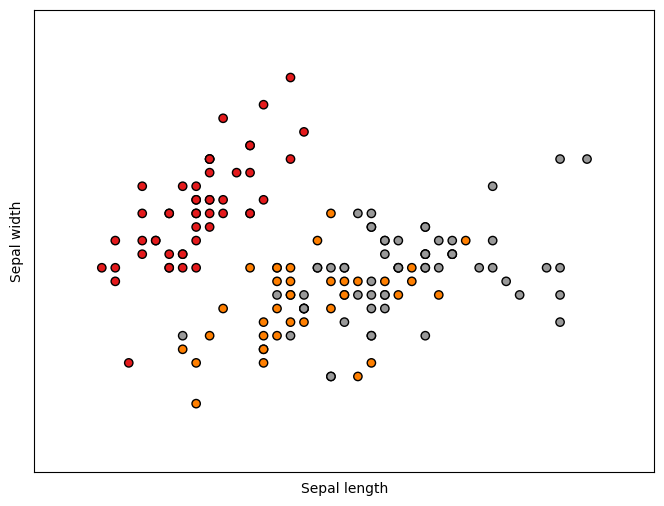

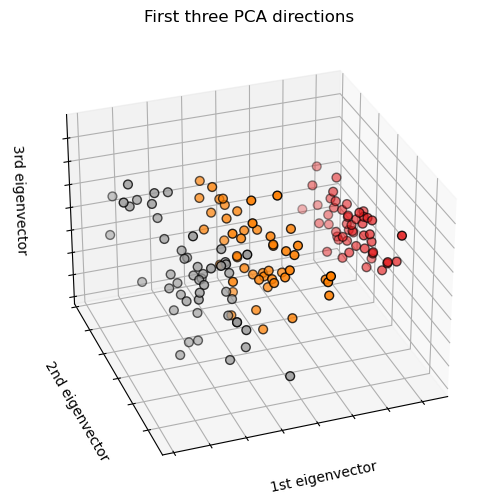

In [24]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

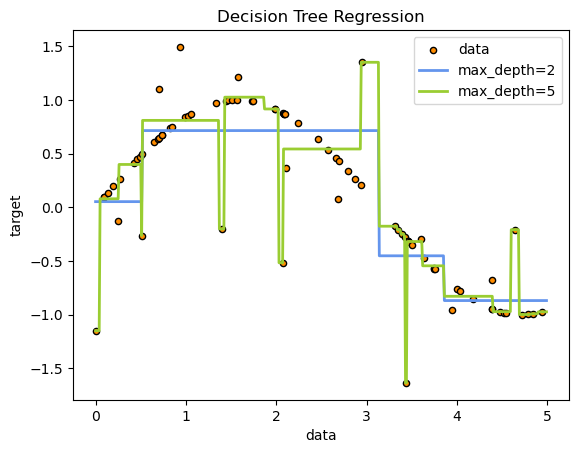

In [25]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

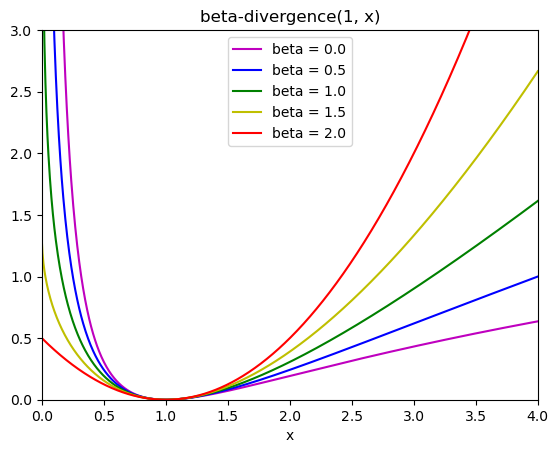

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition._nmf import _beta_divergence

x = np.linspace(0.001, 4, 1000)
y = np.zeros(x.shape)

colors = "mbgyr"
for j, beta in enumerate((0.0, 0.5, 1.0, 1.5, 2.0)):
    for i, xi in enumerate(x):
        y[i] = _beta_divergence(1, xi, 1, beta)
    name = "beta = %1.1f" % beta
    plt.plot(x, y, label=name, color=colors[j])

plt.xlabel("x")
plt.title("beta-divergence(1, x)")
plt.legend(loc=0)
plt.axis([0, 4, 0, 3])
plt.show()

NameError: name 'S' is not defined

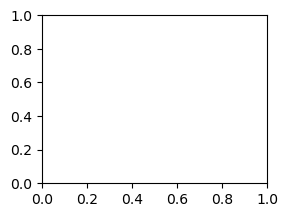

In [29]:
import matplotlib.pyplot as plt


def plot_samples(S, axis_list=None):
    plt.scatter(
        S[:, 0], S[:, 1], s=2, marker="o", zorder=10, color="steelblue", alpha=0.5
    )
    if axis_list is not None:
        for axis, color, label in axis_list:
            axis /= axis.std()
            x_axis, y_axis = axis
            plt.quiver(
                (0, 0),
                (0, 0),
                x_axis,
                y_axis,
                zorder=11,
                width=0.01,
                scale=6,
                color=color,
                label=label,
            )

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel("x")
    plt.ylabel("y")


plt.figure()
plt.subplot(2, 2, 1)
plot_samples(S / S.std())
plt.title("True Independent Sources")

axis_list = [(pca.components_.T, "orange", "PCA"), (ica.mixing_, "red", "ICA")]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(loc="lower right")
legend.set_zorder(100)

plt.title("Observations")

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title("PCA recovered signals")

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title("ICA recovered signals")

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()

<AxesSubplot:xlabel='sex', ylabel='count'>

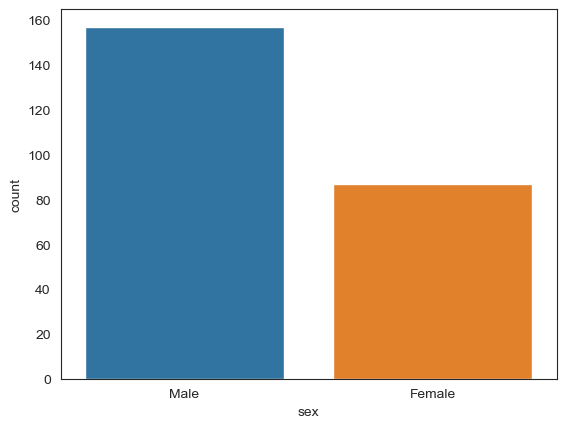

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# load the tips dataset present by default in seaborn
tips = sns.load_dataset('tips')
sns.set_style('white')

# make a countplot
sns.countplot(x ='sex', data = tips)

<AxesSubplot:xlabel='sex', ylabel='count'>

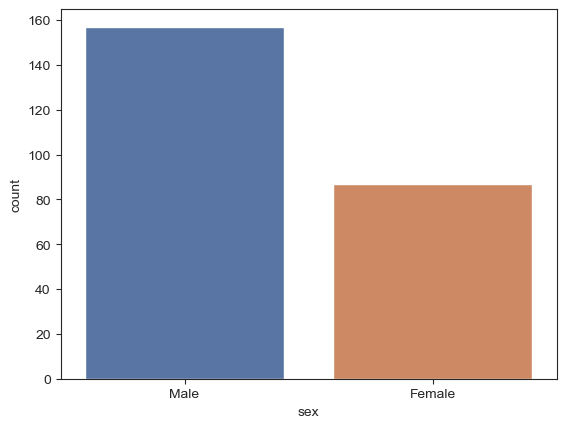

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

tips = sns.load_dataset('tips')
sns.set_style('ticks')
sns.countplot(x ='sex', data = tips, palette = 'deep')

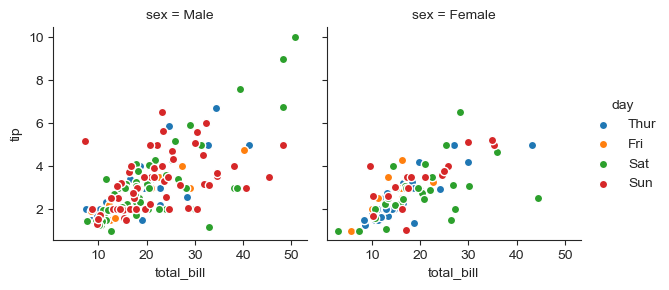

In [35]:
# importing packages
import seaborn
import matplotlib.pyplot as plt

# loading of a dataframe from seaborn
df = seaborn.load_dataset('tips')

############# Main Section		 #############
# Form a facetgrid using columns with a hue
graph = seaborn.FacetGrid(df, col ="sex", hue ="day")
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "total_bill", "tip", edgecolor ="w").add_legend()
# show the object
plt.show()

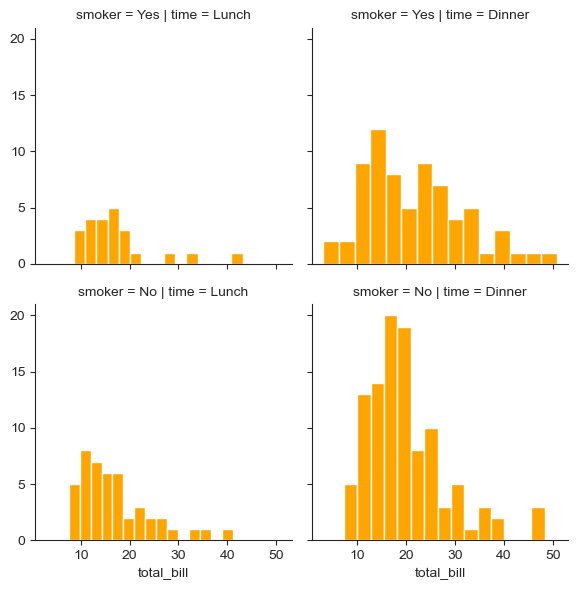

In [36]:
# importing packages
import seaborn
import matplotlib.pyplot as plt

# loading of a dataframe from seaborn
df = seaborn.load_dataset('tips')

############# Main Section		 #############
# Form a facetgrid using columns with a hue
graph = seaborn.FacetGrid(df, row ='smoker', col ='time')
# map the above form facetgrid with some attributes
graph.map(plt.hist, 'total_bill', bins = 15, color ='orange')
# show the object
plt.show()

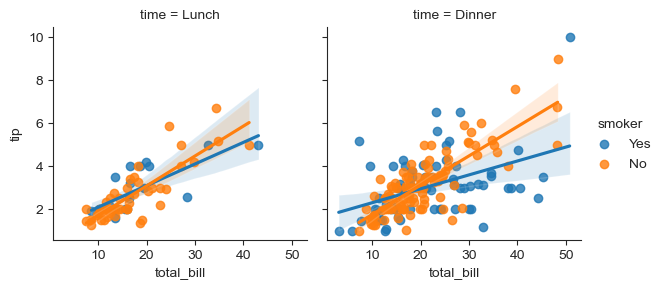

In [37]:
# importing packages
import seaborn
import matplotlib.pyplot as plt

# loading of a dataframe from seaborn
df = seaborn.load_dataset('tips')

############# Main Section		 #############
# Form a facetgrid using columns with a hue
graph = seaborn.FacetGrid(df, col ='time', hue ='smoker')
# map the above form facetgrid with some attributes
graph.map(seaborn.regplot, "total_bill", "tip").add_legend()
# show the object
plt.show()

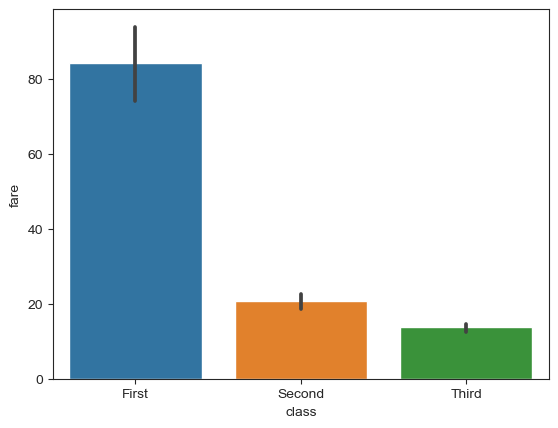

In [38]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt

df = sns.load_dataset('titanic')

# class v / s fare barplot
sns.barplot(x = 'class', y = 'fare', data = df)

# Show the plot
plt.show()

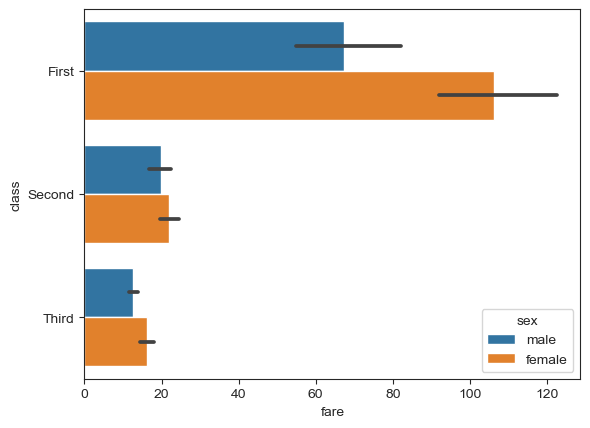

In [39]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt

# read a titanic.csv file
# from seaborn library
df = sns.load_dataset('titanic')

# fare v / s class horizontal barplot
sns.barplot(x = 'fare', y = 'class', hue = 'sex', data = df)

# Show the plot
plt.show()

In [42]:
# Import Beautiful Soup
from bs4 import BeautifulSoup

# Initialize the object with a HTML page
soup = BeautifulSoup('''
	<html>
		<h2> Heading 1 </h2>
		<h1> Heading 2 </h1>
	</html>
	''', "lxml")

# Get the whole h2 tag
tag = soup.h2

# Print the tag
print(tag)

<h2> Heading 1 </h2>


In [43]:
# Import Beautiful Soup
from bs4 import BeautifulSoup

# Initialize the object with a HTML page
soup = BeautifulSoup('''
	
		<h2 class="hello"> Heading 1 </h2>
		<h1> Heading 2 </h1>
	
	''', "lxml")

# Get the whole h2 tag
tag = soup.h2

# Get the attribute
attribute = tag.attrs

# Print the output
print(attribute)

{'class': ['hello']}


In [44]:
# Import Beautiful Soup
from bs4 import BeautifulSoup

# Initialize the object with a HTML page
soup = BeautifulSoup('''
	<html>
		<h2 class="hello"> Heading 1 </h2>
		<h1> Heading 2 </h1>
	</html>
	''', "lxml")

# Get the whole h2 tag
tag = soup.h2

# Get the attribute
attribute = tag.attrs

# Print the output
print(attribute)

{'class': ['hello']}


In [45]:
# Class to make a Node
class Node:
	#Constructor which assign argument to nade's value
	def __init__(self, value):
		self.value = value
		self.next = None

	# This method returns the string representation of the object.
	def __str__(self):
		return "Node({})".format(self.value)
	
	# __repr__ is same as __str__
	__repr__ = __str__


class Stack:
	# Stack Constructor initialise top of stack and counter.
	def __init__(self):
		self.top = None
		self.count = 0
		self.maximum = None
		
	#This method returns the string representation of the object (stack).
	def __str__(self):
		temp=self.top
		out=[]
		while temp:
			out.append(str(temp.value))
			temp=temp.next
		out='\n'.join(out)
		return ('Top {} \n\nStack :\n{}'.format(self.top,out))
		
	# __repr__ is same as __str__
	__repr__=__str__
	
	#This method is used to get minimum element of stack
	def getMax(self):
		if self.top is None:
			return "Stack is empty"
		else:
			print("Maximum Element in the stack is: {}" .format(self.maximum))



	# Method to check if Stack is Empty or not
	def isEmpty(self):
		# If top equals to None then stack is empty
		if self.top == None:
			return True
		else:
		# If top not equal to None then stack is empty
			return False

	# This method returns length of stack	
	def __len__(self):
		self.count = 0
		tempNode = self.top
		while tempNode:
			tempNode = tempNode.next
			self.count+=1
		return self.count

	# This method returns top of stack	
	def peek(self):
		if self.top is None:
			print ("Stack is empty")
		else:
			if self.top.value > self.maximum:
				print("Top Most Element is: {}" .format(self.maximum))
			else:
				print("Top Most Element is: {}" .format(self.top.value))

	#This method is used to add node to stack
	def push(self,value):
		if self.top is None:
			self.top = Node(value)
			self.maximum = value
			
		elif value > self.maximum :
			temp = (2 * value) - self.maximum
			new_node = Node(temp)
			new_node.next = self.top
			self.top = new_node
			self.maximum = value
		else:
			new_node = Node(value)
			new_node.next = self.top
			self.top = new_node
		print("Number Inserted: {}" .format(value))

	#This method is used to pop top of stack
	def pop(self):
		if self.top is None:
			print( "Stack is empty")
		else:
			removedNode = self.top.value
			self.top = self.top.next
			if removedNode > self.maximum:
				print ("Top Most Element Removed :{} " .format(self.maximum))
				self.maximum = ( ( 2 * self.maximum ) - removedNode )
			else:
				print ("Top Most Element Removed : {}" .format(removedNode))

				
			
	
# Driver program to test above class
stack = Stack()

stack.push(3)
stack.push(5)
stack.getMax()
stack.push(7)
stack.push(19)
stack.getMax()	
stack.pop()
stack.getMax()
stack.pop()
stack.peek()

Number Inserted: 3
Number Inserted: 5
Maximum Element in the stack is: 5
Number Inserted: 7
Number Inserted: 19
Maximum Element in the stack is: 19
Top Most Element Removed :19 
Maximum Element in the stack is: 7
Top Most Element Removed :7 
Top Most Element is: 5


C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


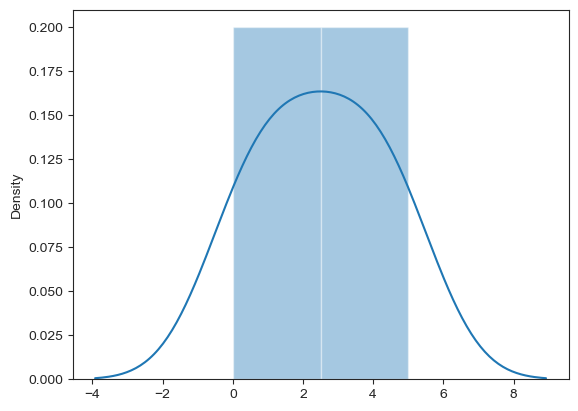

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot([0, 1, 2, 3, 4, 5])

plt.show()

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


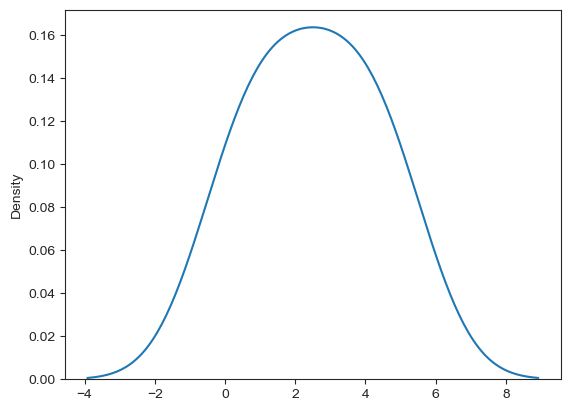

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot([0, 1, 2, 3, 4, 5], hist=False)

plt.show()

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


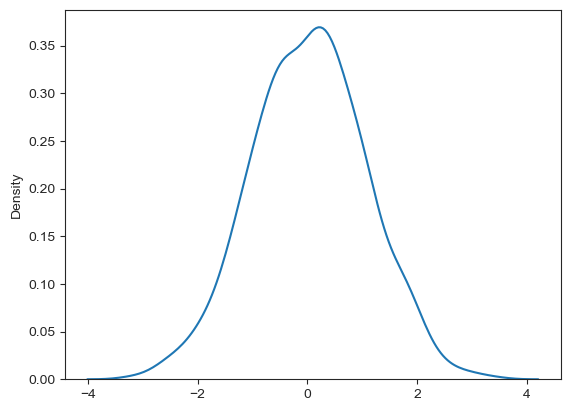

In [48]:
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(random.normal(size=1000), hist=False)

plt.show()